# Forecasting number of Air Passengers #

Este exemplo foi desenvolvido com base no [Repositório de Análise de séries temporais com Python](https://github.com/AileenNielsen/TimeSeriesAnalysisWithPython/blob/master/7.%20Forecasting.ipynb).

In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')


Começamos carregando os dados salvos no arquivo `AirPassengers.csv`.

([<matplotlib.lines.Line2D at 0x1a21361860>], None)

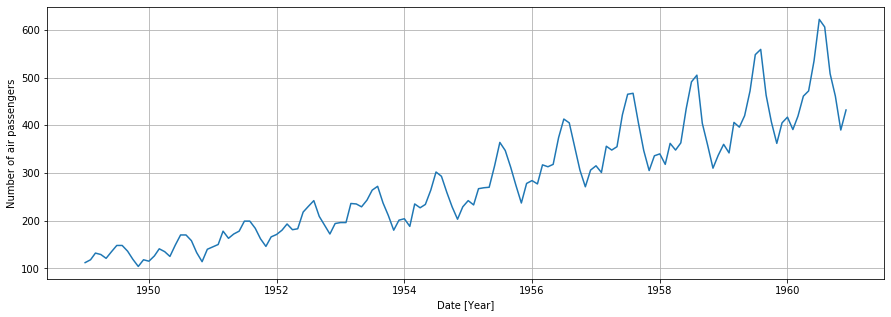

In [2]:
df = pd.read_csv('AirPassengers.csv',
                 parse_dates = ['Month'], index_col = ['Month'])
df.head()
plt.figure(figsize=(15,5))
plt.xlabel('Date [Year]')
plt.ylabel('Number of air passengers')
plt.plot(df), plt.grid()

O primeiro passo para modelar a série temporal é verificar se as informações presentes nos dados são compatíveis com as estruturas de modelos (ARMA) que pretendemos utilizar. À rigor, as estruturas ARMA são apropriadas para modelar séries temporais estacionárias, ou seja, sinais cujas propriedades estatísticas (média e desvio padrão, por exemplo) sejam invariantes no tempo.

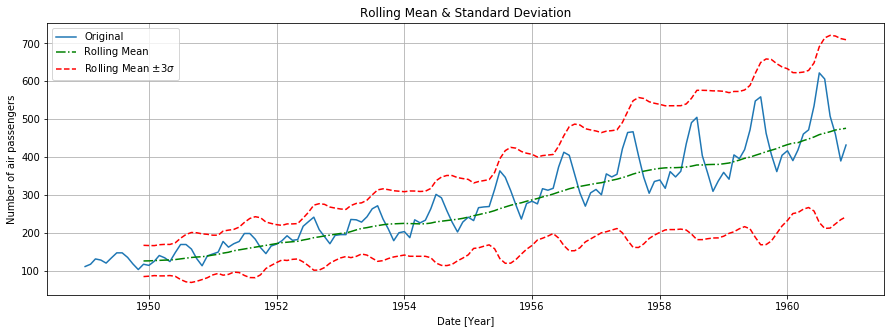

In [3]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.figure(figsize=(15,5))
plt.plot(df, label = 'Original')
plt.plot(rolling_mean, 'g-.', label = 'Rolling Mean')
plt.plot(rolling_mean + 3*rolling_std, 'r--', label = 'Rolling Mean $\pm 3\sigma$')
plt.plot(rolling_mean - 3*rolling_std, 'r--')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date [Year]')
plt.ylabel('Number of air passengers')
plt.grid()
plt.show(block=False)

A figura anterior mostra que a média e o desvio padrão de janelas de dados de 1 ano (12 amostras) variam significativamente com o tempo. O valor p (*p-value*), calculado através do teste de Dickey-Fuller (`statsmodels.tsa.stattools.adfuller`), pode ser usado como um indicador para avaliar se a série temporal pode ser considerada estacionária. Uma espécie de "regra de cabeceira" (consulte, por exemplo, [Marco Peixoto](https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d)) é considerar uma série estacionária se a condição $\text{p-values} < 0.05$ for satisfeita. Uma forma complementar de analisar se uma série é estacionária é verificar se os valores críticos para intervalos de confiança de 1%, 5%, 10% estão suficientemente próxima da estatística ADF (Augmented Dickey-Fuller) [Augmented Dickey-Fuller unit root test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html?highlight=fuller).

In [4]:
result = adfuller(df)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.8153688792060423
p-value: 0.9918802434376409
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


Claramente, a série temporal de passageiros **não** é estacionária. Há certos artifícios que podemos ser usadas para transformar um conjunto de dados em uma série estacionária:
- Considerar o logaritmo natural das amostras;
- Considerar a derivada numérica (diferenciação) da série temporal;
- Aplicar um pré-processamento dos dados usando funções de janelamento.

A seguir, avaliaremos cada algumas dessas alternativas. Para tanto, vamos usar a função `get_stationarity`:

In [5]:
def get_stationarity(timeseries,window=12):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

Primeiro, vamos analisar o que ocorre se consideramos o `log` das amostras.

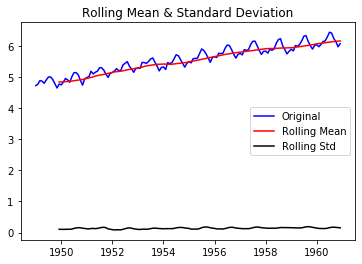

ADF Statistic: -1.7170170891069714
p-value: 0.4223667747703857
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [6]:
df_log = np.log(df)
df_log_rolmean = df_log.rolling(window = 12).mean()
df_log_rolstd = df_log.rolling(window = 12).std()

get_stationarity(df_log)

Apesar de haver alguma melhoria em relação aos dados originais, os testes ainda indicam uma série **não** estacionária. Vamos agora avaliar o que ocorre ao diferenciarmos os dados obtidos anteriormente.

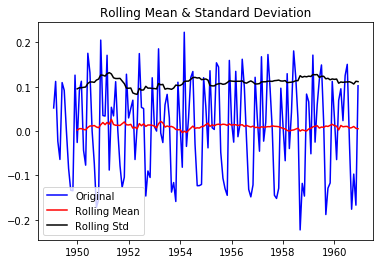

ADF Statistic: -2.717130598388145
p-value: 0.0711205481508568
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


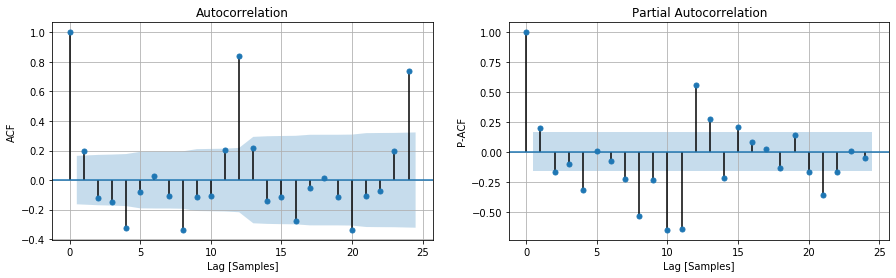

In [7]:
# Diferenciação dos dados
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
plot_acf(df_log_shift,lags=24,ax=ax1)
ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
ax1.grid(True)
plot_pacf(df_log_shift,lags=24,ax=ax2)
ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
ax2.grid(True)
plt.show()

Nota-se que houve uma melhoria considerável, entretanto a condição $\text{p-values} < 0.05$ não satisfeita. Apesar de não ser a situação ideal, utilizaremos esse conjunto de dados para tentar obter um modelo.

In [9]:
dte = df_log

As funções de correlação indicam que precisamos de ao menos um modelo `ARIMA(2,1,2)` para capturar a dinâmica presente na série temporal. Como esse valor é apenas um ponto de partida usaremos o critério de informação de Akaike (AIC) para escolher a estrutura do modelo.

In [22]:
na_s = [0,1,2,3,4,5,6,7,8]
nc_s = [0,1,2,3,4,5,6]
aic_mat = np.zeros((len(na_s),len(nc_s)), dtype=float)

for n_a in na_s:
    for n_c in nc_s:
        modelij = ARIMA(dte, order=(n_a, 1, n_c), trend="t")
        try:
            res = modelij.fit()
            aic_mat[n_a,n_c] = res.aic
        except:
            aic_mat[n_a,n_c] = np.nan

[[-225.64 -228.62 -228.53 -242.98 -259.43 -214.33 -261.70]
 [-226.50 -229.76 -250.37 -245.42 -254.25 -251.57 -256.87]
 [-225.75 -255.34 -245.45 -242.82 -255.81 -243.58 -246.79]
 [-222.14 -252.29 -249.10 -257.69 -251.05 -257.43 -243.58]
 [-232.96 -228.01 -251.86 -257.53 -249.73 -239.45 -288.37]
 [-228.01 -223.07 -248.06 -242.50 -261.33 -234.34 -251.38]
 [-223.89 -245.07 -243.70 -236.65 -250.98 -229.09 -258.28]
 [-225.43 -270.04 -246.00 -235.67 -248.57 -270.59 -294.06]
 [-265.95 -295.97 -287.86 -282.13 -305.83 -304.08 -334.19]]


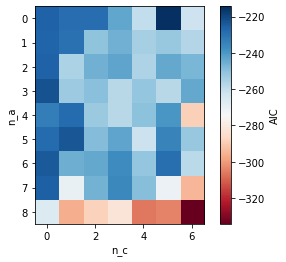

In [23]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
c = ax.imshow(aic_mat, cmap='RdBu')
ax.set_ylabel('n_a'), ax.set_xlabel('n_c')
c_ = fig.colorbar(c, ax=ax)
c_.set_label('AIC')
print(aic_mat)

A inspeção dos valores de AIC para as estruturas consideradas, sugerem a escolha do modelo `ARIMA(4,1,6)`. O próximo passo é avaliar em mais detalhes esse modelo.

In [24]:
model = ARIMA(dte, order=(4,1,6),trend="t")
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 6)   Log Likelihood                 206.798
Date:                Tue, 04 May 2021   AIC                           -381.595
Time:                        17:56:28   BIC                           -334.190
Sample:                    01-01-1949   HQIC                          -362.332
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0098      0.001     11.128      0.000       0.008       0.012
ar.L1          0.1110      0.102      1.084      0.278      -0.090       0.312
ar.L2         -0.0096      0.114     -0.084      0.9

 A função `eval_model` apresenta o ajuste aos dados e as funções de correlação dos resíduos do modelo.

In [25]:
def eval_model(dt,res):
    plt.plot(dt)
    plt.plot(res.fittedvalues[1:], color='red')
    plt.title('Fitted Values')
    plt.xlabel('Date [Year]')
    plt.ylabel('Log of the Number of air passengers')

    # Resíduos do modelo estimado
    resid = res.resid


    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
    plot_acf(resid,lags=24,ax=ax1)
    ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
    ax1.grid(True)
    plot_pacf(resid,lags=24,ax=ax2)
    ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
    ax2.grid(True)
    plt.show()

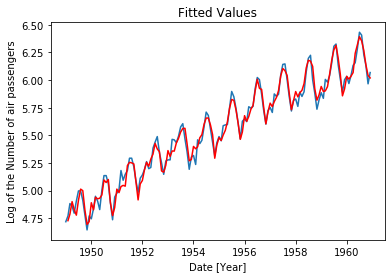

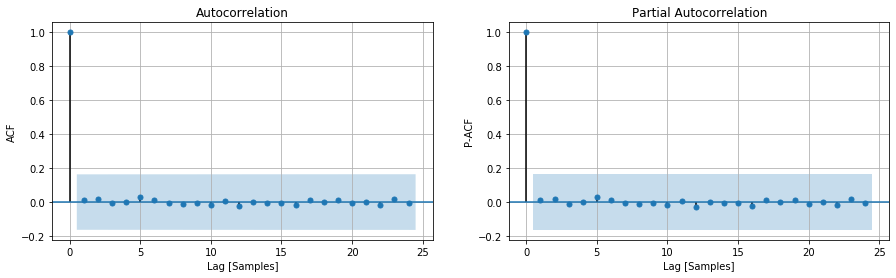

In [26]:
eval_model(dte,res)

Por fim, utilizamos o modelo obtido para tentar prever o número de passageiros nos próximos dois anos.

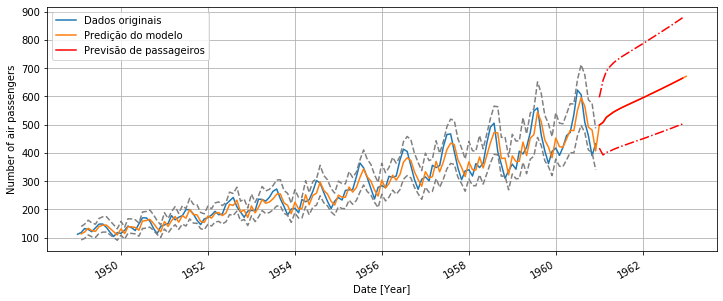

(None, <matplotlib.legend.Legend at 0x1a24a2ba20>, None)

In [17]:
fig, ax = plt.subplots(figsize=(12,5))

# Original data
plt.plot(df,label='Dados originais')

# Model prediction
px = res.predict(start=1, end=len(df)+24)
plt.plot(np.exp(px), label='Predição do modelo')
# Prediction confidence interval
predict_dy = res.get_prediction()
predict_dy_ci = predict_dy.conf_int()
ax.plot(np.exp(predict_dy_ci[1:]),'--',color='gray')


# Forecast - 24 month
fore = res.get_forecast(steps=24)
forecast_ci = fore.conf_int()
plt.plot(np.exp(forecast_ci),'-.',color='red')
forecasts = np.exp(res.forecast(steps=24))
forecasts.plot(color='red',label='Previsão de passageiros')

plt.xlabel('Date [Year]')
plt.ylabel('Number of air passengers')
plt.grid(True), plt.legend(), plt.show()


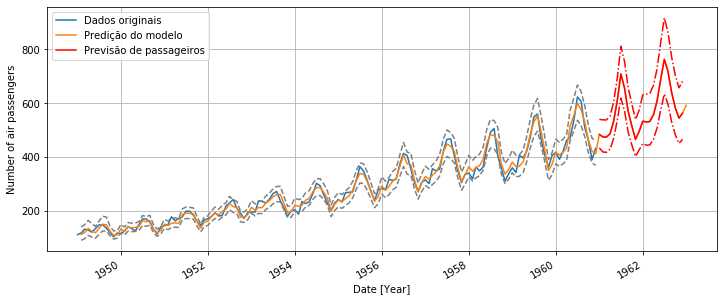

(None, <matplotlib.legend.Legend at 0x1a21358710>, None)

In [27]:
fig, ax = plt.subplots(figsize=(12,5))

# Original data
plt.plot(df,label='Dados originais')

# Model prediction
px = res.predict(start=1, end=len(df)+24)
plt.plot(np.exp(px), label='Predição do modelo')
# Prediction confidence interval
predict_dy = res.get_prediction()
predict_dy_ci = predict_dy.conf_int()
ax.plot(np.exp(predict_dy_ci[1:]),'--',color='gray')


# Forecast - 24 month
fore = res.get_forecast(steps=24)
forecast_ci = fore.conf_int()
plt.plot(np.exp(forecast_ci),'-.',color='red')
forecasts = np.exp(res.forecast(steps=24))
forecasts.plot(color='red',label='Previsão de passageiros')

plt.xlabel('Date [Year]')
plt.ylabel('Number of air passengers')
plt.grid(True), plt.legend(), plt.show()


### Técnicas alternativas de tratamento dos dados ###

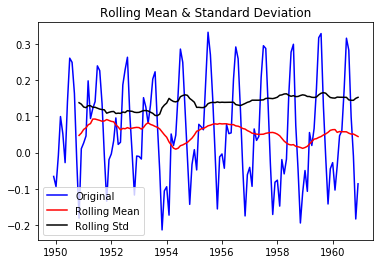

ADF Statistic: -3.162907991300858
p-value: 0.022234630001243844
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


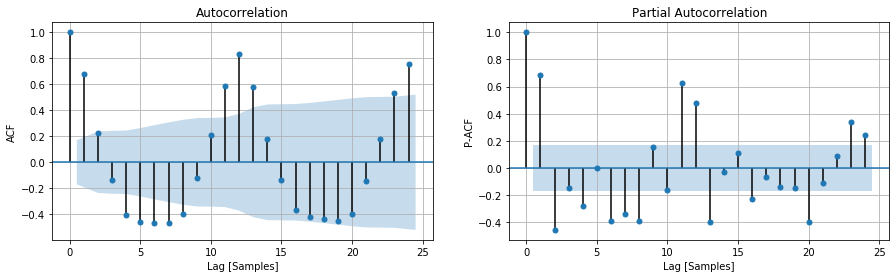

In [28]:
# Remoção da média móvel
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
plot_acf(df_log_minus_mean,lags=24,ax=ax1)
ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
ax1.grid(True)
plot_pacf(df_log_minus_mean,lags=24,ax=ax2)
ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
ax2.grid(True)
plt.show()

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  133
Model:                 ARIMA(8, 1, 6)   Log Likelihood                 196.499
Date:                Tue, 04 May 2021   AIC                           -360.997
Time:                        18:10:27   BIC                           -314.872
Sample:                    12-01-1949   HQIC                          -342.254
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002      0.000     -0.660      0.509      -0.001       0.000
ar.L1          0.1018      0.079      1.288      0.198      -0.053       0.257
ar.L2         -0.0170      0.095     -0.178      0.8

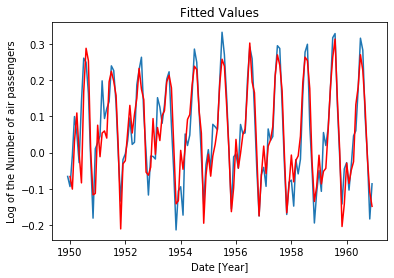

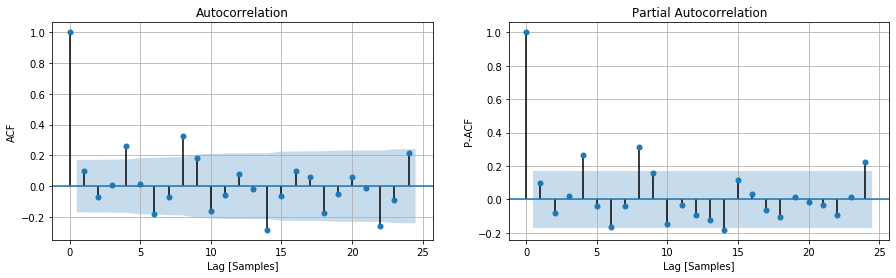

In [31]:
dt = df_log_minus_mean
model = ARIMA(dt, order=(8,1,6),trend="t")
res = model.fit()
print(res.summary())
eval_model(dt,res)

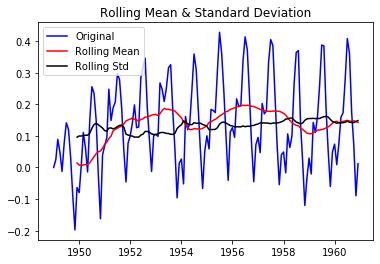

ADF Statistic: -3.60126242016168
p-value: 0.005736938801511833
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


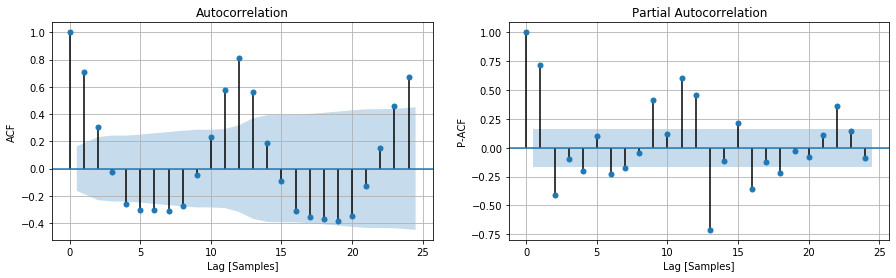

In [32]:
# Aplicação de uma janela exponencial decrescente
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
plot_acf(df_log_exp_decay,lags=24,ax=ax1)
ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
ax1.grid(True)
plot_pacf(df_log_exp_decay,lags=24,ax=ax2)
ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
ax2.grid(True)
plt.show()

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  133
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 129.205
Date:                Tue, 04 May 2021   AIC                           -246.411
Time:                        10:42:09   BIC                           -229.114
Sample:                    12-01-1949   HQIC                          -239.382
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002      0.001     -0.254      0.799      -0.001       0.001
ar.L1          0.1666      0.147      1.133      0.257      -0.122       0.455
ar.L2          0.2311      0.153      1.506      0.1

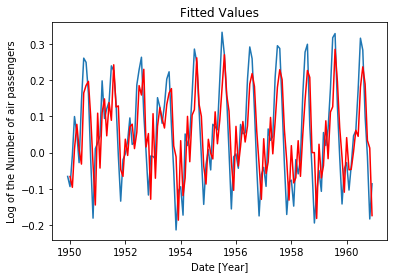

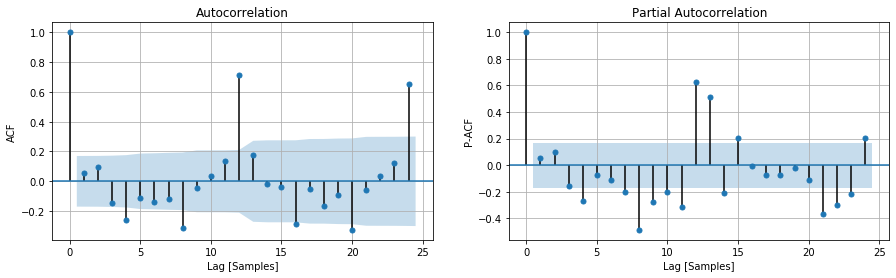

In [38]:
dt = df_log_minus_mean
model = ARIMA(dt, order=(2,1,2),trend="t")
res = model.fit()
print(res.summary())
eval_model(dt,res)